# Sheet 5

In [149]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

# 2) Phase classification in $\phi^4$ theory

(a)

In [83]:
train = np.load("data05/lattice_train.npy")
test = np.load("data05/lattice_test.npy")

L = 16
lattice_shape = (L,L)

train, test = torch.tensor(train), torch.tensor(test)
symmetric_phase_data, broken_phase_data = train[0,...], train[1,...]

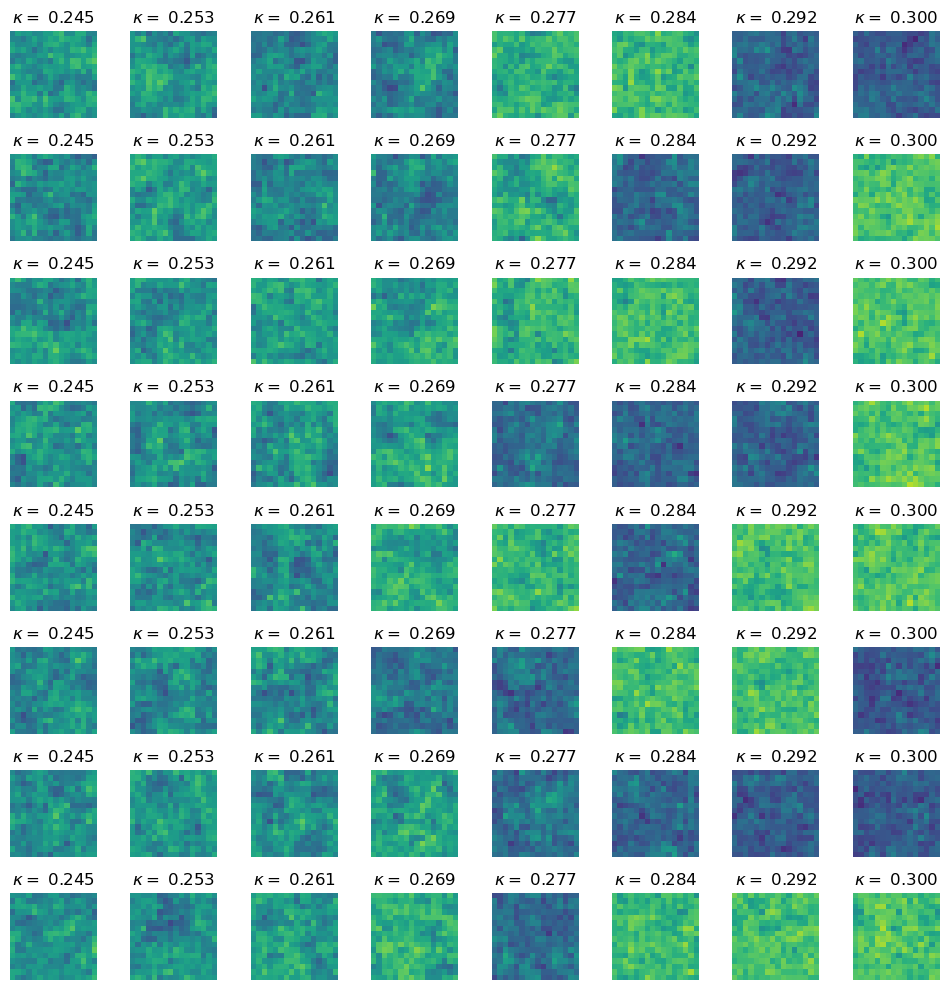

In [8]:
# Visualize lattice sides for different values of kappa
fig, axs = plt.subplots(8, 8, figsize = (10,10), layout = 'tight')

kappas = np.linspace(0.24, 0.3, test.shape[0])

I, J = np.arange(0, 24, 3), np.arange(0, 80, 10)
mesh = np.meshgrid(I, J)

for ax, i, j in np.concatenate([axs[np.newaxis,...], mesh], axis = 0).reshape((3, 8*8)).T:
    ax.set_title(f'$\kappa =$ {kappas[i+2]:.3f}')
    ax.imshow(test[i+2, j, ...], vmin=-5, vmax = 5)
    ax.axis('off')

There seems to be a phase transition at $\kappa^* \sim 0.273$

(b)

In [150]:
# Design a CNN
class CNN(torch.nn.Module):
    def __init__(self, channels, kernel_size):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(1, channels, kernel_size)
        self.conv2 = torch.nn.Conv2d(channels, channels, kernel_size)
        self.pool = torch.nn.AvgPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.dense1 = torch.nn.LazyLinear(4)
        self.dense2 = torch.nn.LazyLinear(1)        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.flatten(self.pool(x), 1)
        x = F.sigmoid(self.dense2(x))

        return x

In [151]:
kappas_train = torch.empty((2, 1000))
kappas_train[0, :] = 0.0
kappas_train[1, :] = 1.0

(c)

In [184]:
# Train CNN
model = CNN(4, 2)

loss_func = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

history = []

for epoch in range(50):
    shuffle = np.random.permutation(range(2000))

    losses = []
    batch_size = 10
    for batch in range(2000 // batch_size):
        batch_indices = shuffle[batch::2000//batch_size]
        batch_input = train.reshape((2000, 1, 16, 16))[batch_indices, ...]
        batch_target = kappas_train.reshape((2000, 1))[batch_indices, ...]

        optimizer.zero_grad()
        outputs = model(batch_input)
        loss = loss_func(outputs, batch_target)
        loss.backward()
        optimizer.step()

        losses.append(loss.detach().item())

    history.append(np.mean(losses))

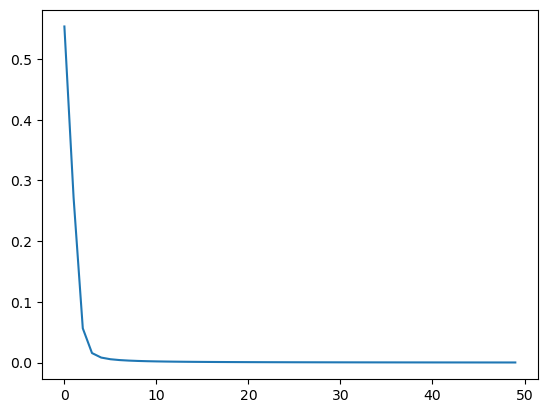

In [185]:
plt.plot(history)

CNN good for tasks with high dependence of neighbours <br>
Kernel size was chosen because the lattice sites only depend on their direct neighbours.

(d)

In [186]:
# Evaluate CNN
kappas_test = np.linspace(0.24, 0.3, 24).reshape((24, 1))

outputs = np.empty((24, 100))

with torch.no_grad():
    for i in range(test.shape[0]):
        test_ = test[i].reshape((100, 1, 16, 16))
        kappa_ = np.linspace(0.24, 0.3)

        outputs[i, :] = model(test_).numpy().flatten()

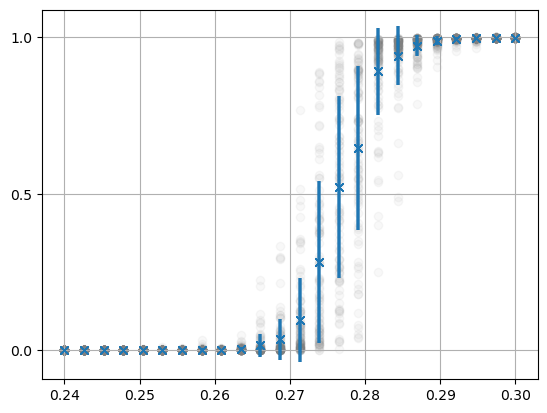

In [187]:
# Plot means and stds
for i in range(24): 
    plt.scatter((kappas_test[i],) * 100, outputs[i], c = 'grey', alpha=0.05)
    plt.errorbar(kappas_test, outputs.mean(axis = 1), outputs.std(axis = 1), fmt='x', color = 'tab:blue')

plt.yticks([0,0.5,1])
plt.grid()

From this plot we can visually infer a critical value of $\kappa ^* = 0.276$

# 3) Uncertainties in Amplitude Regression

In [2]:
# download data to folder data04
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
import os, sys
import wget
from zipfile import ZipFile
from tqdm import tqdm

DESTINATION = "data04"
url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
filename = "tutorial-2-data.zip"
url = url + filename

os.makedirs(DESTINATION, exist_ok=True)
os.chdir(DESTINATION)
wget.download(url, filename)
with ZipFile(filename, "r") as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
        zip_ref.extract(member=file)
%ls
os.chdir("..")

100%|██████████| 11/11 [00:01<00:00,  7.86it/s]

tutorial-2-data/  tutorial-2-data.zip*


In [2]:
# load data
trn_dat = np.load("data04/tutorial-2-data/trn_dat.npy")
trn_amp = np.load("data04/tutorial-2-data/trn_amp.npy")

val_dat = np.load("data04/tutorial-2-data/val_dat.npy")
val_amp = np.load("data04/tutorial-2-data/val_amp.npy")

tst_dat = np.load("data04/tutorial-2-data/tst_dat.npy")
tst_amp = np.load("data04/tutorial-2-data/tst_amp.npy")

print(f"train data shape: {trn_dat.shape}")
print(f"train amp  shape: {trn_amp.shape}")
print(f"test  data shape: {tst_dat.shape}")
print(f"test  amp  shape: {tst_amp.shape}")
print(f"val   data shape: {val_dat.shape}")
print(f"val   amp  shape: {val_amp.shape}")

train data shape: (30000, 5, 4)
train amp  shape: (30000,)
test  data shape: (30000, 5, 4)
test  amp  shape: (30000,)
val   data shape: (30000, 5, 4)
val   amp  shape: (30000,)


(a) 

In [5]:
# TODO: Recycle code from last sheet

In [13]:
# TODO: Train ensemble of deterministic networks

In [1]:
# TODO: Evaluate ensemble -> List of predictions for log A
# result: array preds of shape (10, 30000)

In [6]:
# uncertainties at event level

preds_means = np.mean(np.log(preds), axis=0)
preds_stds = np.std(np.log(preds), axis=0)

plt.hist(np.log(tst_amp), range=(-20, -8), bins=50, alpha=.5)
plt.hist(preds_means, range=(-20, -8), bins=50, alpha=.5)
plt.xlabel(r"$\log A$")
plt.ylabel("bin height")
plt.show()

x = range(len(tst_amp))
plt.fill_between(x, preds_stds, -preds_stds, color="y", label=r"predicted $\sigma_{\log A}$")
plt.plot(x, preds_means - np.log(tst_amp), ",", alpha=.5, ms=.1, label=r"$\log A_\mathrm{pred}-\log A_\mathrm{true}$")
plt.xlabel("# event")
plt.ylim(-1,1)
plt.legend()
plt.show()

# TODO: Interpret results

In [7]:
# uncertainties at histogram level

hist_test, bins = np.histogram(np.log(tst_amp), range=(-20,-8), bins=50)
hist_data = np.array([np.histogram(np.log(preds[i,:]), bins=bins)[0] for i in range(n_models)])
hist_means = np.mean(hist_data, axis=0)
hist_stds = np.std(hist_data, axis=0)

# means
dup_last = lambda a: np.append(a, a[-1])
plt.step(bins, dup_last(hist_test), label="test")
plt.step(bins, dup_last(hist_means), label="ensemble")
plt.xlabel(r"$\log A$")
plt.ylabel("bin height")
plt.legend()
plt.show()

# standard deviations
plt.step(bins, dup_last(np.sqrt(hist_means)), label="statistical uncertainty")
plt.step(bins, dup_last(hist_stds), label="ensemble uncertainty")
plt.xlabel(r"$\log A$")
plt.ylabel("bin standard deviation")
plt.legend()
plt.show()

# means + standard deviations
hists = [hist_test, hist_means]
hist_errors = [np.sqrt(hist_test), hist_stds]
integrals = [np.sum((bins[1:] - bins[:-1])*y) for y in hists]
scales = [1 / integral if integral != 0. else 1. for integral in integrals]

label = ["Test", "ensemble"]
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [3, 1], "hspace": 0.})
for y, y_err, scale, label in zip(hists, hist_errors, scales, label):
    axs[0].step(bins, dup_last(y) * scale, label=label, where="post")
    axs[0].fill_between(bins, dup_last(y + y_err) * scale, 
                     dup_last(y - y_err) * scale, alpha=.5, step="post")
    
    ratio = (y * scale) / (hists[0] * scales[0])
    ratio_err = np.sqrt( (y_err/y)**2 + (hist_errors[0] / hists[0])**2)
    ratio[np.isnan(ratio)] = 1.
    ratio_err[np.isnan(ratio)] = 0.
    
    axs[1].step(bins, dup_last(ratio), where="post")
    axs[1].fill_between(bins, dup_last(ratio + ratio_err), dup_last(ratio - ratio_err), step="post", alpha=.5)
axs[1].set_xlabel(r"$\log A$")
axs[0].set_ylabel("Normalized")
axs[1].set_ylabel(r"$\frac{\mathrm{Ensemble}}{\mathrm{Test}}$")
axs[1].set_ylim(.5, 1.5)
axs[0].legend()
plt.show()

# TODO: Interpret results

(d)

In [16]:
# TODO: Fill in expression for KL divergence
import math

class VBLinear(nn.Module):
    # VB = variational bayes
    def __init__(self, in_features, out_features, prior_prec=1.0, _map=False, std_init=-5):
        super(VBLinear, self).__init__()
        self.n_in = in_features
        self.n_out = out_features
        self.map = _map
        self.prior_prec = prior_prec # = 1/sigma_prior**2
        self.random = None
        self.bias = nn.Parameter(torch.Tensor(out_features))
        self.mu_w = nn.Parameter(torch.Tensor(out_features, in_features))
        self.logsig2_w = nn.Parameter(torch.Tensor(out_features, in_features)) # log(sigma_network**2)
        self.std_init = std_init
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.mu_w.size(1))
        self.mu_w.data.normal_(0, stdv)
        self.logsig2_w.data.zero_().normal_(self.std_init, 0.001)
        self.bias.data.zero_()

    def KL(self):
        logsig2_w = self.logsig2_w.clamp(-11, 11)
        kl = None # KL divergence of variational bayes linear layer 
        return kl

    def forward(self, input):
        if self.training:
            # local reparameterization trick is more efficient and leads to
            # an estimate of the gradient with smaller variance.
            # https://arxiv.org/pdf/1506.02557.pdf
            mu_out = nn.functional.linear(input, self.mu_w, self.bias)
            logsig2_w = self.logsig2_w.clamp(-11, 11)
            s2_w = logsig2_w.exp()
            var_out = nn.functional.linear(input.pow(2), s2_w) + 1e-8
            return mu_out + var_out.sqrt() * torch.randn_like(mu_out)

        else:
            if self.map: # just return the mean, no sampling
                return nn.functional.linear(input, self.mu_w, self.bias)

            logsig2_w = self.logsig2_w.clamp(-11, 11)
            if self.random is None:
                self.random = torch.randn_like(self.logsig2_w)
            s2_w = logsig2_w.exp()
            weight = self.mu_w + s2_w.sqrt() * self.random
            return nn.functional.linear(input, weight, self.bias) + 1e-8

In [17]:
# TODO: Create BNN (like deterministic network, but with bayesian layers)

class bayesian_amp_net(nn.Module):
    
    def __init__(self, training_size, ipt_dim=20, opt_dim=1, hdn_dim=32, n_layers=2):
        pass

    def forward(self, x):
        pass
    
    def KL(self):
        kl = 0
        for layer in self.bayesian_layers:
            kl += layer.KL()
        return kl
    
    def reset_BNN(self):
        for layer in self.bayesian_layers:
            layer.random = None

In [8]:
def batch_loss_bayesian(model, x, y):
    x, y = x.to(device), y.to(device)
    pred = model(x)
    loss = loss_fn(pred, y)
    kl = model.KL() / trn_dat.shape[0] # correct normalization!
    loss += kl
    return loss

In [9]:
# TODO: Train BNN

(e)

In [21]:
# TODO: Evaluate BNN

In [10]:
# uncertainties at event level

preds_means = np.mean(np.log(preds), axis=0)
preds_stds = np.std(np.log(preds), axis=0)

plt.hist(np.log(tst_amp), range=(-20, -8), bins=50, alpha=.5)
plt.hist(preds_means, range=(-20, -8), bins=50, alpha=.5)
plt.xlabel(r"$\log A$")
plt.ylabel("bin height")
plt.show()

x = range(len(tst_amp))
plt.fill_between(x, preds_stds, -preds_stds, color="y", label=r"predicted $\sigma_{\log A}$")
plt.plot(x, preds_means - np.log(tst_amp), ",", alpha=.5, ms=.1, label=r"$\log A_\mathrm{pred}-\log A_\mathrm{true}$")
plt.xlabel("# event")
plt.ylim(-1,1)
plt.legend()
plt.show()

# TODO: Interpret results

In [11]:
# uncertainties at histogram level

hist_test, bins = np.histogram(np.log(tst_amp), range=(-20,-8), bins=50)
hist_data = np.array([np.histogram(np.log(preds[i,:]), bins=bins)[0] for i in range(n_models)])
hist_means = np.mean(hist_data, axis=0)
hist_stds = np.std(hist_data, axis=0)

# means
dup_last = lambda a: np.append(a, a[-1])
plt.step(bins, dup_last(hist_test), label="test")
plt.step(bins, dup_last(hist_means), label="ensemble")
plt.xlabel(r"$\log A$")
plt.ylabel("bin height")
plt.legend()
plt.show()

# standard deviations
plt.step(bins, dup_last(np.sqrt(hist_means)), label="statistical uncertainty")
plt.step(bins, dup_last(hist_stds), label="ensemble uncertainty")
plt.xlabel(r"$\log A$")
plt.ylabel("bin standard deviation")
plt.legend()
plt.show()

# means + standard deviations
hists = [hist_test, hist_means]
hist_errors = [np.sqrt(hist_test), hist_stds]
integrals = [np.sum((bins[1:] - bins[:-1])*y) for y in hists]
scales = [1 / integral if integral != 0. else 1. for integral in integrals]

label = ["Test", "ensemble"]
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [3, 1], "hspace": 0.})
for y, y_err, scale, label in zip(hists, hist_errors, scales, label):
    axs[0].step(bins, dup_last(y) * scale, label=label, where="post")
    axs[0].fill_between(bins, dup_last(y + y_err) * scale, 
                     dup_last(y - y_err) * scale, alpha=.5, step="post")
    
    ratio = (y * scale) / (hists[0] * scales[0])
    ratio_err = np.sqrt( (y_err/y)**2 + (hist_errors[0] / hists[0])**2)
    ratio[np.isnan(ratio)] = 1.
    ratio_err[np.isnan(ratio)] = 0.
    
    axs[1].step(bins, dup_last(ratio), where="post")
    axs[1].fill_between(bins, dup_last(ratio + ratio_err), dup_last(ratio - ratio_err), step="post", alpha=.5)
axs[1].set_xlabel(r"$\log A$")
axs[0].set_ylabel("Normalized")
axs[1].set_ylabel(r"$\frac{\mathrm{Ensemble}}{\mathrm{Test}}$")
axs[1].set_ylim(.5, 1.5)
axs[0].legend()
plt.show()

# TODO: Interpret results